# Problem statement
building a composer classifier based on live captured audio that can be set to stream chunks of data to our model at 15, 30, 60-second intervals if desired. Several hundred audio files they have collected and annotated and saved as simple midi files. The PS1 folder contains midi files pertaining to Bach, Beethoven, Schubert and Brahms. The goal of this problem is to develop a robust classifier that determines the composer. 

In the folder PS2, we have some unlabeled files that contain midis of pieces written by the same 4 composers AS WELL as three (3) files written by a 5th unknown composer. The goal of the project is to determine which pieces they are and quantify the uncertainty regarding your determination.
 
# Preprocessing the MIDI files
***As a Data Scientist, I've learned the amount of time I spend in Data Preprocessing, Data Exploration and Feature Engineering will be always paid off by an accurate model in the end***

Midi files type 1 (synchronous) contain information of tracks that all start at the same time. 
**The information that I extracted directly from midi files are:**
* ticks per beat for each song so called TPQ : `mid.ticks_per_beat`
* tempo for each song: find the first message that contain `set_tempo` information with `time=0`
* frequency code of the note, or so-called note numbers for each message at each track: `note=n`
* velocity (how hard the key is pressed): `velocity=v`
* keyoard state: `note_on` or `note_off`
* tick or so-called time in the metadata: the waiting time between the last and current operation. 
* channel number (not sure if I want to use it later, but I rathered not to loose it)

**The features that I created for later in this:**

* binary note array: I assign each tick a binary label vector with 128 dimensions correspond to frequency codes for notes. For example a note with code 32 would be assigned $vector = [0 0 ....1....0]$ which $vector[32]=1$
* accuumulated tick: `accum_ticks'= 'current_tick'+'accum_ticks'
* absulute time using tempo, current tick and tick per beat: $t= \frac{TccumulatedTick\times Tempo}{10^-6\times TPQ}$
* trackid : a unique if per file per track, this id comes very handy in both preprocessing and prediction of the unseen data
* note duration: The duration of a note is the sum of "tick” from each message in between of 2 nearest messages about the same note
* assign the composer_label to each row of data, this would be beneficial for classification and prediction tasks 


**Then I created the 15,30 and 60 seconds data chunks as follows:**:

* removing the rows with `note_off` keys or 0 note duration (this feature has been created at the previous step)
* creating 128 features for each note and sum over the chunk, which gives the information on note repetition and sum over 
* sum of each 128 note duration over the chunk     
* removing the notes that they have not played at all, which result in total 86 piano notes,




**Under sampling for Beethoven category**
Since this category has 132 data which is much more than other categories, we undersample the files when reading the files. The desired number of files to be read is chosen based on the average of number of files at other three clases, i.e., $int(\frac{39+20+25}{3})=28$. Therefore, for the undersampling task, I create a list of 28 random index from all 132 file index and I read only the files with the chosen random index.

The following figure shows the note frequency for Beethoven category before and after undersampling

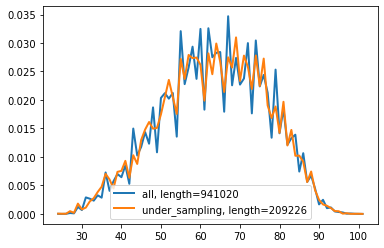




I will explain the logic behind the feature extraction when presenting my slides in details.In short, based on the figures provided at the Data Exploratory part, the most important features are the note frequency, i.e., repetition of notes and note duration. 

****note repetition****
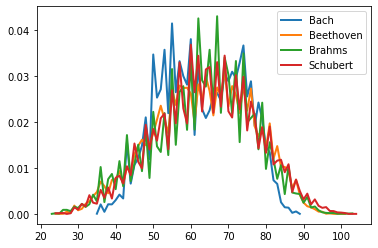

****note duration****

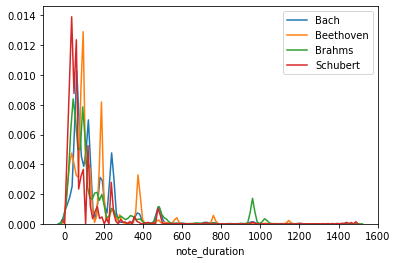



**At the end I preprocessed the unseen data the same way as for the training data.**

In [3]:
import pandas as pd
import numpy as np
import mido
import os
import string
import matplotlib.pyplot as plt
import random
import seaborn as sns


In [4]:
path = '......\\data\\PS1\\'

In [5]:
music_category = ['Bach','Beethoven','Brahms','Schubert']
music_category_dict = dict()
for category in music_category:
    os.chdir(path+category)
    music_category_dict [category] = os.listdir()

In [176]:
note_data = pd.read_csv(path+'note_data_v2', index_col=[0])
note_data.head(10)

,keyboard_state,channel,note_number,velocity,trackid,ticks,note_duration,accum_ticks,seconds,TPQ,...,note_119,note_120,note_121,note_122,note_123,note_124,note_125,note_126,note_127,note_128
0,note_on,0,60,100,0_1_1862,0,240,0,0.000000,480,...,0,0,0,0,0,0,0,0,0,0
1,note_on,0,60,0,0_1_1862,240,0,240,0.428571,480,...,0,0,0,0,0,0,0,0,0,0
2,note_on,0,59,100,0_1_1862,0,120,240,0.428571,480,...,0,0,0,0,0,0,0,0,0,0
3,note_on,0,59,0,0_1_1862,120,0,360,0.642857,480,...,0,0,0,0,0,0,0,0,0,0
4,note_on,0,57,100,0_1_1862,0,120,360,0.642857,480,...,0,0,0,0,0,0,0,0,0,0
5,note_on,0,57,0,0_1_1862,120,0,480,0.857143,480,...,0,0,0,0,0,0,0,0,0,0
6,note_on,0,55,100,0_1_1862,0,120,480,0.857143,480,...,0,0,0,0,0,0,0,0,0,0
7,note_on,0,55,0,0_1_1862,120,0,600,1.071429,480,...,0,0,0,0,0,0,0,0,0,0
8,note_on,0,53,100,0_1_1862,0,120,600,1.071429,480,...,0,0,0,0,0,0,0,0,0,0
9,note_on,0,53,0,0_1_1862,120,0,720,1.285715,480,...,0,0,0,0,0,0,0,0,0,0


## under sampling for Beethoven category

In [6]:
random_index_Beethoven = random.sample(range(0,len(music_category_dict ['Beethoven'])), int(np.mean([39,20,25])))

## get message information Class

In [7]:
# this class extract all the information we need from a message
class Message:
    
    def __init__(self, message,info_type):
        message = self.message
        info_type=['tempo','time','note_','channel','note','velocity']
        
    def parse_info(info_type,message):
        if info_type=='note_':
            info = message[message.rfind(info_type):].split(' ')[0].translate(str.maketrans({a: None for a in [",","'"]}))
        else:
            info = int(message[message.rfind(info_type):].split(' ')[0].split('=')[1].
                   translate(str.maketrans({a: None for a in string.punctuation})))
        return info
                   
    def contain_note(message):
        return ('note_on' in message or 'note_off' in message)

    def contain_tempo(message):
        return 'set_tempo' in message

    def get_tempo(message):
        tempo = Message.parse_info('tempo',message)
        return tempo
    
    def get_tick(message):
        time = Message.parse_info('time',message)
        return time
    
    def get_note_number(message):
        note_number = Message.parse_info('note',message)
        return note_number
    
    def get_velocity(message):
        velocity = Message.parse_info('velocity',message)
        return velocity
    
    def get_keyboard_state(message):
        keyboard_state = Message.parse_info('note_',message)
        return keyboard_state
    
    def get_channel(message):
        channel = Message.parse_info('channel',message)
        return channel
        

## get all tracks information functions

In [8]:
def get_note_list(note_number):
    note_list = [0]*128
    note_list[note_number]=1
    return note_list

def get_all_info(mid_metadata,label,thresh,tpq,file_number,tempo=500000):
    all_info_list =[]
    tracks_len = [len(tr) for tr in mid_metadata.tracks]
    min_n_msg = max(tracks_len)*thresh
    # track counter
    i = 0
    for track in mid_metadata.tracks:
        # initializing the tickstamp
        ts = 0
        # creating track id from length of track and track counter
        track_id=str(file_number)+'_'+str(i)+'_'+str(len(track))
        if len(track)>=min_n_msg:
            for msg in track:
                msg_info_list = []
                msg = str(msg)
                if Message.contain_tempo(msg):
                    tempo = Message.get_tempo(msg)
                    tick = Message.get_tick(msg)
#                     print(tempo,tick)
                    break
                if Message.contain_note(msg):
                    # get keyboard state, note number,tick,velocity and channel
                    s = Message.get_keyboard_state(msg)
                    t = Message.get_tick(msg)
                    v = Message.get_velocity(msg)
                    n = Message.get_note_number(msg)
                    c = Message.get_channel(msg)
                    # accumulated tick at each timestamp
                    ts=t+ts
                    # the absolute time in seconds
                    seconds=(tempo*1e-6/tpq)*ts
                    # initializing the tick duration, later we update this number
                    tick_duration = t
                    msg_info_list = [s,c,n,v,track_id,t,tick_duration,ts,seconds,tpq,label]
                    note_binary_list = get_note_list(n)
                    all_info_list.append(msg_info_list + note_binary_list)
                
        i+=1
    print('tempo=',tempo)
    return all_info_list


## get tick duration functions

In [9]:
# get the nearest note number
def same_nearest_note_index(list_,jj):
    # 2 is the index of note_number column 
    note_number = list_[jj][2]
    for i in range(jj-1,-1,-1):
        if list_[i][2]==note_number:
#             print(i)
            break
    return i
# update the tick duration
def update_tick_duration(info_list):
#     info_array= np.array(info_list)
    # 6 is the index note_duration column 
    # the first note duration needs to be 0 even if the absolute starting time is not zero
    info_list[0][6]=0
    # initializing the list of indices that have been found through the loop
    seen_indices=[]
    for i in range(len(info_list)-1,0,-1):
        if i not in seen_indices:
            # find the index of the same nearest note
            ind =  same_nearest_note_index(info_list,i)
            # update the note duration for both notes
            info_list[ind][6]=info_list[i][6]-info_list[ind][6]
            # reverse negative duration to original duration
            if info_list[ind][6] < 0:
                info_list[ind][6]=info_list[i][6]             
            info_list[i][6]=0
            seen_indices.append(ind)
    return info_list

In [12]:
threshold = 0.00
# creating data for each category
cols1 = ['keyboard_state','channel','note_number','velocity','trackid','ticks','note_duration','accum_ticks','seconds','TPQ','composer_label']
cols2 = ['note_'+str(i+1) for i in range(128)]
cols = cols1+cols2
note_data= pd.DataFrame(columns=cols)
for category in music_category[:1]:
    if category == 'Beethoven':
        for i in random_index_Beethoven:
            mid_metadata=mido.MidiFile(path+category+"\\"+music_category_dict[category][i], clip=True)
            category_info_list = get_all_info(mid_metadata,category,threshold,mid_metadata.ticks_per_beat,i)
            # updating the tick duration
            category_info_array = update_tick_duration(category_info_list)
            note_data = pd.concat([note_data,pd.DataFrame(category_info_array,columns=cols)])
            print('category=', category,'file number=',i, 'ticks_per_beat=',mid_metadata.ticks_per_beat)

    else:
#         for i in range(len(music_category_dict[category])):
        for i in range(7,8):
            mid_metadata=mido.MidiFile(path+category+"\\"+music_category_dict[category][i], clip=True)
            print('category=', category,'file number=',i, 'ticks_per_beat=',mid_metadata.ticks_per_beat)
            category_info_list = get_all_info(mid_metadata,category,threshold,mid_metadata.ticks_per_beat,i)
            # updating the tick duration
            category_list_info_updated = update_tick_duration(category_info_list)
            note_data = pd.concat([note_data,pd.DataFrame(category_list_info_updated,columns=cols)])

category= Bach file number= 7 ticks_per_beat= 480
tempo= 240000


In [13]:
mid_metadata

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='untitled', time=0),
    MetaMessage('smpte_offset', frame_rate=24, hours=0, minutes=0, seconds=3, frames=18, sub_frames=0, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='Eb', time=0),
    MetaMessage('set_tempo', tempo=240000, time=0),
    MetaMessage('set_tempo', tempo=357143, time=1440),
    MetaMessage('marker', text='I A', time=480),
    MetaMessage('marker', text="I A'", time=23040),
    MetaMessage('marker', text='I B', time=23040),
    MetaMessage('marker', text="I B'", time=69120),
    MetaMessage('marker', text='II A', time=69120),
    MetaMessage('marker', text="II A'", time=7680),
    MetaMessage('marker', text='II B', time=7680),
    MetaMessage('marker', text="II B'", time=15360),
    MetaMessage('marker', text="I A''", time=15360),
    MetaMessage('marker',

## converting beats data into 15,30 and 60s chunks

In [189]:
path = '....\\data\\PS1\\'
chunks = [15,30,60]
remain_threshold = [10,20,40]
cols = ['note_repeat_'+str(i+1) for i in range(128)]+['duration_note_'+str(i+1) for i in range(128)]+['trackid','TPQ','composer_label']
# the data without note-off keys
note_data_cl = note_data[~(note_data.note_duration==0)]
for ch,thresh in zip(chunks,remain_threshold):
    all_chunks =[]
    # note velocity, and note duration,along with label and TPQ
    for category_group in note_data_cl.groupby(['composer_label']):
        print(category_group[0])
        for track_group in category_group[1].groupby(['trackid']):
            c_label = category_group[0]
            TPQ = track_group[1].TPQ.max()
            # find the starting and ending seconds of a track
            track_start, track_end = min(track_group[1].seconds),max(track_group[1].seconds)
            # find the track duration
            track_duration = track_end - track_start
            # get the size of the last chunk
            remain = track_duration%ch
            # number of chunks in a track
            number_of_chunks = int(track_duration//ch)
            for nc in range(number_of_chunks):
                data_chunk = track_group[1][(track_group[1].seconds>= nc*ch+track_start)&(track_group[1].seconds<(nc+1)*ch+track_start)]
                if len(data_chunk):
                    note_repeat = list(data_chunk[['note_'+str(i+1) for i in range(128)]].sum())
                    note_duration = list(np.dot(data_chunk['note_duration'],data_chunk[['note_'+str(i+1) for i in range(128)]]))
                    note_chunk_list = note_repeat+note_duration+[track_group[0],TPQ,c_label]
                    all_chunks.append(note_chunk_list)
            if remain>=thresh:
                data_chunk = track_group[1][track_group[1].seconds>= (number_of_chunks+1)*thresh+track_start]
                if len(data_chunk):
                    note_repeat = list(data_chunk[['note_'+str(i+1) for i in range(128)]].sum())
                    note_duration = list(np.dot(data_chunk['note_duration'],data_chunk[['note_'+str(i+1) for i in range(128)]]))
                    note_chunk_list = note_repeat+note_duration+[track_group[0],TPQ,c_label]
                    all_chunks.append(note_chunk_list)
    note_chunks = pd.DataFrame(all_chunks,columns=cols)
    note_chunks.to_csv(path+'note_chunk_'+str(ch)+'.csv')

Bach
Beethoven
Brahms
Schubert
Bach
Beethoven
Brahms
Schubert
Bach
Beethoven
Brahms
Schubert


# Removing zeros columns:
notes that have not been played

In [191]:
path = '...\\data\\PS1\\'
# finding zeros percentage in every column
chunks = [15,30,60]
for ch in chunks:
    note_chunks = pd.read_csv(path+'note_chunk_'+str(ch)+'.csv', index_col = [0])
    print(len(note_chunks))
    note_chunks_cleaned = note_chunks.copy()
    for c in cols[:256]:
        num_zeros = sum(note_chunks[c]==0)
        zeros_perc=num_zeros/len(note_chunks)*100
        # removing the note columns that have not been played
        if zeros_perc==100:
            note_chunks_cleaned = note_chunks_cleaned.drop(c, 1)
    print(len(note_chunks_cleaned.columns))
    note_chunks_cleaned.to_csv(path+'note_chunk_cleaned_'+str(ch)+'.csv')
        


8507
167
4310
167
2156
167


# Data Exploratory

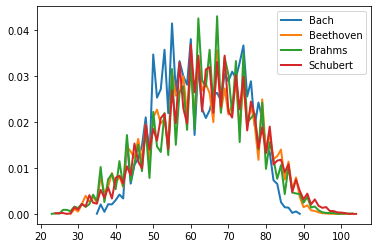

In [210]:
fig, ax = plt.subplots()
# comparing frequency for all composers
for group in note_data.groupby(['composer_label']):
    group_note = group[1]
    note_frequency = group_note.groupby(['note_number'])['note_number'].count()
    norm_note_freq = note_frequency/sum(note_frequency)
    ax.plot(norm_note_freq.index, norm_note_freq,linewidth=2,label=group[0])
    plt.legend()
#     plt.show()

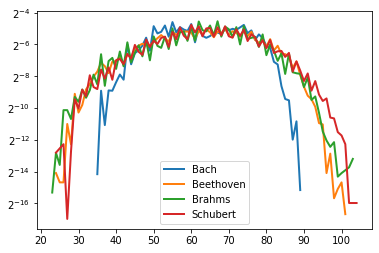

In [658]:
fig, ax = plt.subplots()
# comparing frequency for all composers
for group in note_data.groupby(['composer_label']):
    group_note = group[1]
    note_frequency = group_note.groupby(['note_number'])['note_number'].count()
    norm_note_freq = note_frequency/sum(note_frequency)
    ax.plot(norm_note_freq.index, norm_note_freq,linewidth=2,label=group[0])
    ax.set_yscale('log', basey=2)
    plt.legend()
#     plt.show()


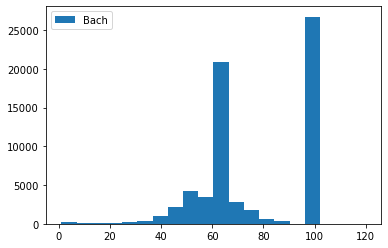

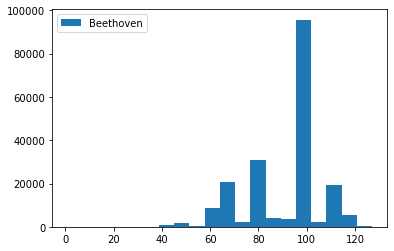

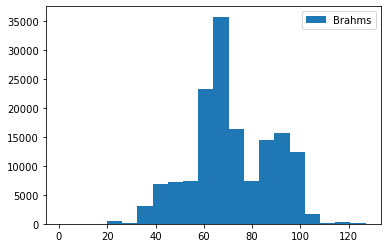

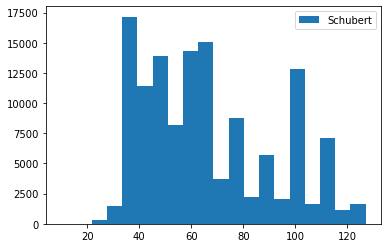

In [664]:
fig, ax = plt.subplots()
# comparing frequency for all composers
for group in note_data.groupby(['composer_label']):
    group_ = group[1]
    velocity_group = group_[group_['velocity']!=0]['velocity']
    plt.hist(velocity_group,bins=20,label=group[0])
#     ax.set_ylim([0,])
    plt.legend()
    plt.show()

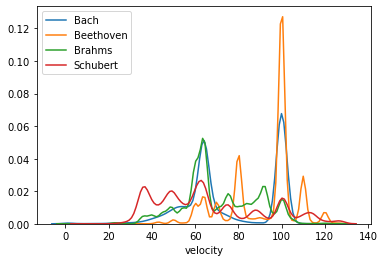

In [680]:
# comparing frequency for all composers
for group in note_data.groupby(['composer_label']):
    group_ = group[1]
    velocity_group = group_[group_['velocity']!=0]['velocity']
    sns.distplot(velocity_group, hist=False, label=group[0])
    


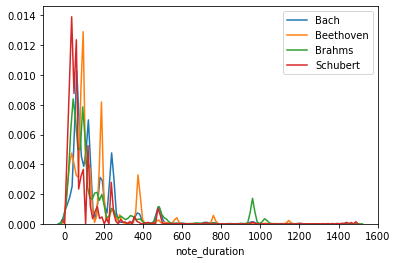

In [683]:
# comparing frequency for all composers
for group in note_data.groupby(['composer_label']):
    group_ = group[1]
    note_group = group_[(group_['note_duration']>0)&(group_['note_duration']<1500)]['note_duration']
    sns.distplot(note_group, hist=False, label=group[0])
    


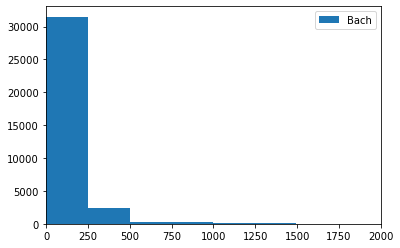

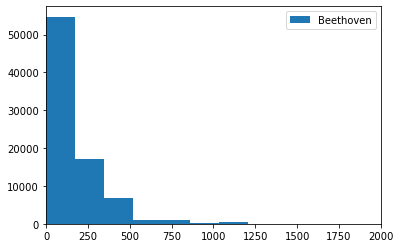

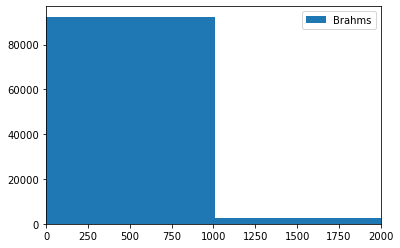

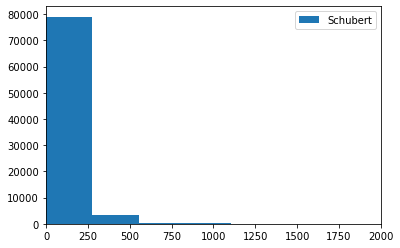

In [666]:
fig, ax = plt.subplots()
# comparing frequency for all composers
for group in note_data.groupby(['composer_label']):
    group_ = group[1]
    note_group = group_[group_['note_duration']!=0]['note_duration']
    plt.hist(note_group,bins=20,label=group[0])
    plt.xlim(0,2000)
    plt.legend()
    plt.show()

In [492]:
# comparing Beethoven data before and after the sampling
threshold = 0.00
# creating data for each category
cols1 = ['keyboard_state','channel','note_number','velocity','trackid','ticks','accum_ticks','seconds','TPQ','composer_label']
cols2 = ['note_'+str(i+1) for i in range(128)]
cols = cols1+cols2
note_data_beethoven= pd.DataFrame(columns=cols)
note_data_beethoven_all= pd.DataFrame(columns=cols)
category = 'Beethoven'
for i in random_index_Beethoven:
    mid_metadata=mido.MidiFile(path+category+"\\"+music_category_dict[category][i], clip=True)
    category_info_list = get_all_info(mid_metadata,category,threshold,mid_metadata.ticks_per_beat)
    note_data_beethoven = pd.concat([note_data_beethoven,pd.DataFrame(category_info_list,columns=cols)])
    print('category=', category,'type=',mid_metadata.type, 'ticks_per_beat=',mid_metadata.ticks_per_beat)

for i in range(len(music_category_dict[category])):
    mid_metadata=mido.MidiFile(path+category+"\\"+music_category_dict[category][i], clip=True)
    category_info_list = get_all_info(mid_metadata,category,threshold,mid_metadata.ticks_per_beat)
    note_data_beethoven_all = pd.concat([note_data_beethoven_all,pd.DataFrame(category_info_list,columns=cols)])
    print('category=', category,'type=',mid_metadata.type, 'ticks_per_beat=',mid_metadata.ticks_per_beat)



tempo= 2500000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 2727272
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 857142
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 461538
category= Beethoven type= 1 ticks_per_beat= 240
tempo= 666666
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 400000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 400000
category= Beethoven type= 1 ticks_per_beat= 256
tempo= 400000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 500000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 666666
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 400000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 1714285
category= Beethoven type= 1 ticks_per_beat= 256
tempo= 1500000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 1333333
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 857142
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 400000
category= Beethoven type= 1 ticks_per_beat= 384
tem

category= Beethoven type= 1 ticks_per_beat= 384
tempo= 1071428
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 220588
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 3333333
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 375000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 666666
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 1000000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 1250000
category= Beethoven type= 1 ticks_per_beat= 192
tempo= 1071428
category= Beethoven type= 1 ticks_per_beat= 192
tempo= 600000
category= Beethoven type= 1 ticks_per_beat= 192
tempo= 461538
category= Beethoven type= 1 ticks_per_beat= 256
tempo= 555555
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 2500000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 300000
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 555555
category= Beethoven type= 1 ticks_per_beat= 384
tempo= 400000
category= Beethoven type= 1 ticks_per_beat= 256
tempo= 1714285
c

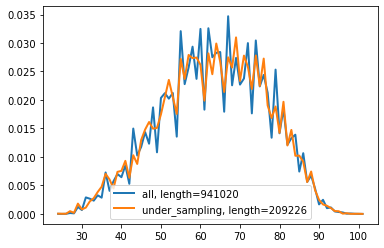

In [497]:
note_frequency = note_data_beethoven_all.groupby(['note_number'])['note_number'].count()
norm_note_freq = note_frequency/sum(note_frequency)
plt.plot(norm_note_freq.index, norm_note_freq,linewidth=2,label='all, length='+str(len(note_data_beethoven_all)))
note_frequency = note_data_beethoven.groupby(['note_number'])['note_number'].count()
norm_note_freq = note_frequency/sum(note_frequency)
plt.plot(norm_note_freq.index, norm_note_freq,linewidth=2,label='under_sampling, length='+str(len(note_data_beethoven)))
plt.legend()
#     plt.show()

In [483]:
for group in note_data.groupby(['composer_label']):
    group_velocity = group[1]
    velocity_mean_group = group_velocity[group_velocity['velocity']!=0]['velocity'].mean()
    print(group[0],velocity_mean_group)


Bach 76.85467250249559
Beethoven 91.63254880032534
Brahms 71.06540476814251
Schubert 66.24712657076913


# preprocessing the unseen data: PS2


In [181]:
path = '....\\data\\PS2\\'


In [170]:
os.chdir(path)
file_names = os.listdir()


In [195]:
file_names

['0.002716920481628_adj.mid',
 '0.033313986422223163_adj.mid',
 '0.047574444458241216_adj.mid',
 '0.06402123326764841_adj.mid',
 '0.07186746659481313_adj.mid',
 '0.09167358800381353_adj.mid',
 '0.10222964826466285_adj.mid',
 '0.10250888365879718_adj.mid',
 '0.10630249969742178_adj.mid',
 '0.1755252422917658_adj.mid',
 '0.1960551158929671_adj.mid',
 '0.21198476749665085_adj.mid',
 '0.21901852969811753_adj.mid',
 '0.22047111832936944_adj.mid',
 '0.23120017256495873_adj.mid',
 '0.26551079719260606_adj.mid',
 '0.30993012400290976_adj.mid',
 '0.3264565808984162_adj.mid',
 '0.3334293069825759_adj.mid',
 '0.33695573887576447_adj.mid',
 '0.337517805339117_adj.mid',
 '0.3559970176888735_adj.mid',
 '0.3620067189216978_adj.mid',
 '0.36321860283443286_adj.mid',
 '0.48367685897240176_adj.mid',
 '0.539512676743813_adj.mid',
 '0.549470161204349_adj.mid',
 '0.5807329043589801_adj.mid',
 '0.647959423719129_adj.mid',
 '0.7491289879531658_adj.mid',
 '0.8014751784512073_adj.mid',
 '0.905499891236923_adj.m

In [198]:
path = '....\\data\\PS2\\'
threshold = 0.00
cols1 = ['keyboard_state','channel','note_number','velocity','trackid','ticks','note_duration','accum_ticks','seconds','TPQ','composer_label']
cols2 = ['note_'+str(i+1) for i in range(128)]
cols = cols1+cols2
note_data_test= pd.DataFrame(columns=cols)
category = 'Unknown'
for i,file in enumerate(file_names):
    mid_metadata=mido.MidiFile(path+"\\"+file, clip=True)
    print('file number=',i, 'ticks_per_beat=',mid_metadata.ticks_per_beat)
    category_info_list = get_all_info(mid_metadata,category,threshold,mid_metadata.ticks_per_beat,i)
    # updating the tick duration
    category_list_info_updated = update_tick_duration(category_info_list)
    note_data_test = pd.concat([note_data_test,pd.DataFrame(category_list_info_updated,columns=cols)])

file number= 0 ticks_per_beat= 240
tempo= 1250000
file number= 1 ticks_per_beat= 384
tempo= 555555
file number= 2 ticks_per_beat= 120
tempo= 416667
file number= 3 ticks_per_beat= 384
tempo= 200000
file number= 4 ticks_per_beat= 240
tempo= 612245
file number= 5 ticks_per_beat= 480
tempo= 857143
file number= 6 ticks_per_beat= 480
tempo= 240000
file number= 7 ticks_per_beat= 384
tempo= 631578
file number= 8 ticks_per_beat= 384
tempo= 222222
file number= 9 ticks_per_beat= 480
tempo= 240000
file number= 10 ticks_per_beat= 240
tempo= 476190
file number= 11 ticks_per_beat= 120
tempo= 833333
file number= 12 ticks_per_beat= 120
tempo= 1304348
file number= 13 ticks_per_beat= 240
tempo= 441176
file number= 14 ticks_per_beat= 384
tempo= 468750
file number= 15 ticks_per_beat= 192
tempo= 300000
file number= 16 ticks_per_beat= 384
tempo= 480000
file number= 17 ticks_per_beat= 384
tempo= 2000000
file number= 18 ticks_per_beat= 120
tempo= 1153846
file number= 19 ticks_per_beat= 384
tempo= 187500
file n

In [207]:
chunks = [15,30,60]
remain_threshold = [10,20,40]
cols = ['note_repeat_'+str(i+1) for i in range(128)]+['duration_note_'+str(i+1) for i in range(128)]+['trackid','TPQ','composer_label']
# the data without note-off keys
note_data_test_cl = note_data_test[~(note_data_test.note_duration==0)]
for ch,thresh in zip(chunks,remain_threshold):
    print(ch)
    all_chunks =[]
    # note velocity, and note duration,along with label and TPQ
    for track_group in note_data_test_cl.groupby(['trackid']):
        c_label = ['Unknown']
        TPQ = track_group[1].TPQ.max()
        # find the starting and ending seconds of a track
        track_start, track_end = min(track_group[1].seconds),max(track_group[1].seconds)
        # find the track duration
        track_duration = track_end - track_start
        # get the size of the last chunk
        remain = track_duration%ch
        # number of chunks in a track
        number_of_chunks = int(track_duration//ch)
        for nc in range(number_of_chunks):
            data_chunk = track_group[1][(track_group[1].seconds>= nc*ch+track_start)&(track_group[1].seconds<(nc+1)*ch+track_start)]
            if len(data_chunk):
                note_repeat = list(data_chunk[['note_'+str(i+1) for i in range(128)]].sum())
                note_duration = list(np.dot(data_chunk['note_duration'],data_chunk[['note_'+str(i+1) for i in range(128)]]))
                note_chunk_list = note_repeat+note_duration+[track_group[0],TPQ,c_label]
                all_chunks.append(note_chunk_list)
        if remain>=thresh:
            data_chunk = track_group[1][track_group[1].seconds>= (number_of_chunks+1)*thresh+track_start]
            if len(data_chunk):
                note_repeat = list(data_chunk[['note_'+str(i+1) for i in range(128)]].sum())
                note_duration = list(np.dot(data_chunk['note_duration'],data_chunk[['note_'+str(i+1) for i in range(128)]]))
                note_chunk_list = note_repeat+note_duration+[track_group[0],TPQ,c_label]
                all_chunks.append(note_chunk_list)
    note_chunks = pd.DataFrame(all_chunks,columns=cols)
    note_chunks.to_csv(path+'note_chunk_test_'+str(ch)+'.csv')

15
30
60


In [209]:
path = "\\data\\"

# removing the same columns that have been removed in tarining data
columns_list = note_chunks_cleaned.columns
chunks = [15,30,60]
for ch in chunks:
    note_chunks = pd.read_csv(path+'note_chunk_test_'+str(ch)+'.csv', index_col = [0])
    print(len(note_chunks))
    note_chunks_cleaned = note_chunks.copy()
    for c in note_chunks.columns:
        if c not in columns_list:
            note_chunks_cleaned = note_chunks_cleaned.drop(c, 1)
    print(len(note_chunks_cleaned.columns))
    note_chunks_cleaned.to_csv(path+'note_chunk_cleaned_test_'+str(ch)+'.csv')
        


2088
167
1058
167
525
167
